# Process the zscore data into form for cytoscape

In [1]:
# import matplotlib
# matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import community

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

% matplotlib inline

import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations

from IPython.display import display


In [2]:
import sys
sys.path.append('/Users/brin/Google_Drive/UCSD/cluster_code/pyvenn-master/')
import venn

# Load the STRING interactome

In [3]:
Gint = nx.read_gpickle('/Users/brin/Documents/CCBB_tickets_data/STRING/human/G_str_181022.gpickle')
print(len(Gint.nodes()))
print(len(Gint.edges()))

15131
359776


# Load the seed genes

In [4]:
import string

# load HC genes
AMLvsAN_genes = pd.read_csv('AMLvsAN_seed_genes_190509.tsv',sep='\t',index_col='Unnamed: 0')
MFvsAN_genes = pd.read_csv('MFvsAN_seed_genes_190509.tsv',sep='\t',index_col='Unnamed: 0')
AMLvsMF_genes = pd.read_csv('AMLvsMF_seed_genes_190509.tsv',sep='\t',index_col='Unnamed: 0')

seed_AMLvsAN = AMLvsAN_genes['seed_genes'].tolist()[0].translate(None,string.punctuation).split(' ')
print(len(seed_AMLvsAN))
seed_AMLvsAN = list(np.intersect1d(seed_AMLvsAN,Gint.nodes())) # only keep seed genes in the interactome
print(len(seed_AMLvsAN))

seed_MFvsAN = MFvsAN_genes['seed_genes'].tolist()[0].translate(None,string.punctuation).split(' ')
print(len(seed_MFvsAN))
seed_MFvsAN = list(np.intersect1d(seed_MFvsAN,Gint.nodes())) # only keep seed genes in the interactome
print(len(seed_MFvsAN))

seed_AMLvsMF = AMLvsMF_genes['seed_genes'].tolist()[0].translate(None,string.punctuation).split(' ')
print(len(seed_AMLvsMF))
seed_AMLvsMF = list(np.intersect1d(seed_AMLvsMF,Gint.nodes())) # only keep seed genes in the interactome
print(len(seed_AMLvsMF))

744
572
815
614
155
122


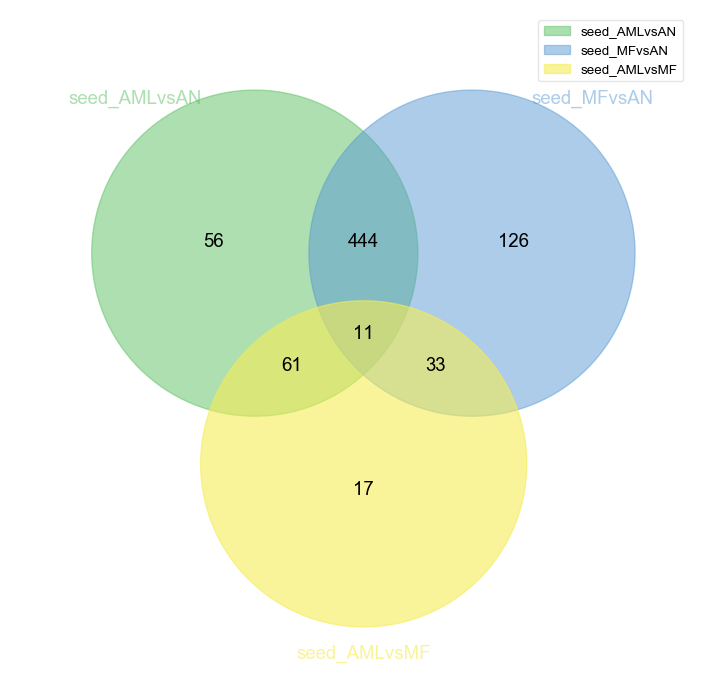

In [5]:
# plot the overlap in subgraphs
labels = venn.get_labels([seed_AMLvsAN,seed_MFvsAN,seed_AMLvsMF])
fig, ax = venn.venn3(labels, names=['seed_AMLvsAN', 'seed_MFvsAN','seed_AMLvsMF'])
# plt.savefig('../figures/seed_gene_overlap_venn5.png',dpi=300,bbox_inches='tight')

# Load the zscore data

In [6]:
zthresh=2
num_reps=5000

AMLvsAN_z = pd.read_csv('zscore_results/190509/z_seed_AMLvsAN'+str(num_reps)+'_repsSTRING_degree_binning.tsv',sep='\t',names=['symbol','z'])
AMLvsAN_z.index=AMLvsAN_z['symbol']
AMLvsAN_z=AMLvsAN_z.sort_values('z',ascending=False)
AMLvsAN_z_genes = AMLvsAN_z[AMLvsAN_z['z']>zthresh].index.tolist()
print(len(AMLvsAN_z_genes))

MFvsAN_z = pd.read_csv('zscore_results/190509/z_seed_MFvsAN'+str(num_reps)+'_repsSTRING_degree_binning.tsv',sep='\t',names=['symbol','z'])
MFvsAN_z.index=MFvsAN_z['symbol']
MFvsAN_z=MFvsAN_z.sort_values('z',ascending=False)
MFvsAN_z_genes = MFvsAN_z[MFvsAN_z['z']>zthresh].index.tolist()
print(len(MFvsAN_z_genes))

AMLvsMF_z = pd.read_csv('zscore_results/190509/z_seed_AMLvsMF'+str(num_reps)+'_repsSTRING_degree_binning.tsv',sep='\t',names=['symbol','z'])
AMLvsMF_z.index=AMLvsMF_z['symbol']
AMLvsMF_z=AMLvsMF_z.sort_values('z',ascending=False)
AMLvsMF_z_genes = AMLvsMF_z[AMLvsMF_z['z']>zthresh].index.tolist()
print(len(AMLvsMF_z_genes))

1814
1848
705


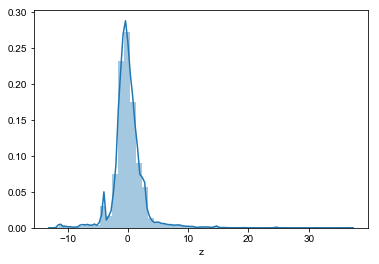

In [7]:
sns.distplot(AMLvsAN_z['z'].dropna())

# Make a subgraph based on the selected single z-score data

In [33]:
# set the seed genes
seed_type = 'AMLvsMF' # seed type can be 'AMLvsAN','MFvsAN','AMLvsMF'
if seed_type=='AMLvsAN':
    seed_genes=seed_AMLvsAN
    z_df = AMLvsAN_z
    z_genes = AMLvsAN_z_genes
elif seed_type=='MFvsAN':
    seed_genes = seed_MFvsAN
    z_df = MFvsAN_z
    z_genes = MFvsAN_z_genes
elif seed_type=='AMLvsMF':
    seed_genes=seed_AMLvsMF
    z_df = AMLvsMF_z
    z_genes = AMLvsMF_z_genes
    
# we will save results here in savedir
savedir = '190509/'+seed_type+'_zscore_'+str(zthresh)
import os
if not os.path.exists(savedir):
    os.mkdir(savedir)
print(len(seed_genes))
print(len(z_genes))

122
705


In [34]:
savedir

'190509/AMLvsMF_zscore_2'

In [35]:
# subgraph
G_sub = nx.subgraph(Gint,z_genes)

In [36]:
print(len(G_sub.nodes()))
print(len(G_sub.edges()))

705
1841


In [37]:
gsub_edgelist = pd.DataFrame(columns=['node1','node2'])

for e in G_sub.edges():
    gsub_edgelist = gsub_edgelist.append(pd.DataFrame({'node1':[e[0]],'node2':[e[1]]}))
    
gsub_edgelist.to_csv(savedir+'/edgelist.tsv',sep='\t',index=False)

In [38]:
# only partition the LCC
partition = pd.Series(community.best_partition(max(nx.connected_component_subgraphs(G_sub), key=len)))
partition_VC = partition.value_counts()
partition_VC

0     60
12    56
14    50
9     46
16    42
4     42
2     33
11    33
6     33
7     31
5     29
1     27
3     24
20    15
8     14
13    14
15    14
18    14
17    13
10    11
19     8
dtype: int64

In [39]:
# map the partition number to size of partition
partition_to_rank = dict(zip(partition_VC.index.tolist(),np.arange(len(partition_VC))+1))

prank = []
for p in partition.tolist():
    prank.append(partition_to_rank[p])
    
print(len(prank))
prank = pd.Series(prank,index=partition.index)
prank.value_counts()

609


1     60
2     56
3     50
4     46
5     42
6     42
7     33
8     33
9     33
10    31
11    29
12    27
13    24
14    15
15    14
16    14
17    14
18    14
19    13
20    11
21     8
dtype: int64

In [40]:
# write out results table
node_info_df = pd.DataFrame(np.zeros((len(G_sub.nodes()),4)))
node_info_df.columns = ['partition','partition_rank','zscore','seed_node']
node_info_df['partition']=node_info_df['partition']-1 # set unclustered nodes to -1
node_info_df['partition_rank']=node_info_df['partition_rank']-1 # set unclustered nodes to -1
node_info_df.index =G_sub.nodes()

node_info_df['partition'].loc[partition.index.tolist()]=partition
node_info_df['partition_rank'].loc[prank.index.tolist()]=prank

node_info_df['zscore']=z_df['z']


node_info_df['seed_node'].loc[list(np.intersect1d(G_sub.nodes(),seed_genes))]=1.0

node_info_df.to_csv(savedir+'/node_info.csv')

node_info_df.head()



,partition,partition_rank,zscore,seed_node
SMARCC1,0.0,1.0,6.976643,1.0
SYNPO,1.0,12.0,2.265089,0.0
FHIT,2.0,7.0,2.703023,0.0
PRKAG1,3.0,13.0,2.485204,0.0
HSPA9,0.0,1.0,5.308376,1.0


# Gprofiler enrichment of clusters

In [41]:
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

In [42]:
import os

savedir_profile = savedir+'/gprofile_cluster'
if not os.path.isdir(savedir_profile):
    os.mkdir(savedir_profile)


cluster2top_pathway = pd.DataFrame(columns=['cluster','pathway','term_ID','p-value','num_genes_in_cluster'])
for focal_cluster in prank.value_counts().index.tolist():
    print(focal_cluster)
    focal_genes = prank[prank==focal_cluster].index.tolist()
    if len(focal_genes)>10:
        gp_results = pd.DataFrame(gp.gprofile(focal_genes,custom_bg = partition.index.tolist(),correction_method=gp.THR_FDR))

        gp_results.columns = ["query.number", "significant", "p.value", "term.size",
                              "query.size", "overlap.size", "recall", "precision",
                              "term.id", "domain", "subgraph.number", "term.name",
                              "relative.depth", "intersection"]
        print(gp_results[['p.value','term.id','term.name']].head())
        cluster2top_pathway = cluster2top_pathway.append(pd.DataFrame({'cluster':[focal_cluster],
                                                                      'pathway':gp_results.loc[0]['term.name'],
                                                                       'term_ID':gp_results.loc[0]['term.id'],
                                                                      'p-value':gp_results.loc[0]['p.value'],
                                                                      'num_genes_in_cluster':[len(focal_genes)]}),
                                                        ignore_index=True)

        writer = pd.ExcelWriter(savedir_profile+'/cluster_'+str(focal_cluster)+'.xlsx')
        gp_results.to_excel(writer)
        writer.save()

#gp_results = pd.DataFrame(gp.gprofile(focal_genes,correction_method=gp.THR_FDR))

1
        p.value           term.id  \
0  4.990000e-08        GO:0000307   
1  4.990000e-08        GO:1902554   
2  2.540000e-07        GO:0004693   
3  2.540000e-07        GO:0097472   
4  3.500000e-06  REAC:R-HSA-69278   

                                           term.name  
0  cyclin-dependent protein kinase holoenzyme com...  
1            serine/threonine protein kinase complex  
2  cyclin-dependent protein serine/threonine kina...  
3           cyclin-dependent protein kinase activity  
4                                Cell Cycle, Mitotic  
2
    p.value     term.id                                          term.name
0  0.000005  GO:0000981  DNA-binding transcription factor activity, RNA...
1  0.000005  GO:0046983                      protein dimerization activity
2  0.000020  GO:0003700          DNA-binding transcription factor activity
3  0.000031  GO:0140110                   transcription regulator activity
4  0.000041  GO:0003676                               nucleic acid b

   p.value            term.id  \
0  0.00171         CORUM:6734   
1  0.00262  REAC:R-HSA-425393   
2  0.00391  REAC:R-HSA-425407   
3  0.01610          CORUM:275   
4  0.01610         CORUM:2198   

                                           term.name  
0                                    9b-1b-1 complex  
1  Transport of inorganic cations/anions and amin...  
2               SLC-mediated transmembrane transport  
3                                      9-1-1 complex  
4                                 9-1-1-POLB complex  
20
        p.value             term.id  \
0  3.750000e-09          GO:0035329   
1  2.720000e-08          KEGG:04392   
2  2.270000e-06          KEGG:04390   
3  1.050000e-04  REAC:R-HSA-2028269   
4  1.130000e-03          GO:0035331   

                                    term.name  
0                             hippo signaling  
1  Hippo signaling pathway - multiple species  
2                     Hippo signaling pathway  
3                          Signaling by H

In [43]:
# write out the top pathway for each cluster
cluster2top_pathway.to_csv(savedir+'/cluster2top_pathway.csv',index=False)
cluster2top_pathway

,cluster,num_genes_in_cluster,p-value,pathway,term_ID
0,1,60,4.990000e-08,cyclin-dependent protein kinase holoenzyme com...,GO:0000307
1,2,56,4.960000e-06,"DNA-binding transcription factor activity, RNA...",GO:0000981
2,3,50,6.800000e-18,Chromatin organization,REAC:R-HSA-4839726
3,4,46,6.960000e-12,ubiquitin-protein transferase activity,GO:0004842
4,5,42,4.590000e-14,N-glycan trimming in the ER and Calnexin/Calre...,REAC:R-HSA-532668
5,6,42,2.000000e-27,vesicle-mediated transport,GO:0016192
6,7,33,4.510000e-02,GINS complex,CORUM:678
7,8,33,3.580000e-12,Translation,REAC:R-HSA-72766
8,9,33,2.500000e-06,Major pathway of rRNA processing in the nucleo...,REAC:R-HSA-6791226
9,10,31,3.840000e-10,M Phase,REAC:R-HSA-68886


In [44]:
# run the enrichment for the full subgraph
import os

savedir_profile = savedir
print(savedir_profile)
if not os.path.isdir(savedir_profile):
    os.mkdir(savedir_profile)
    
focal_genes = G_sub.nodes()
print(len(focal_genes))
if len(focal_genes)>10:
    gp_results = pd.DataFrame(gp.gprofile(focal_genes,custom_bg = Gint.nodes(),correction_method=gp.THR_FDR))

    gp_results.columns = ["query.number", "significant", "p.value", "term.size",
                          "query.size", "overlap.size", "recall", "precision",
                          "term.id", "domain", "subgraph.number", "term.name",
                          "relative.depth", "intersection"]
    print(gp_results[['p.value','term.id','term.name']].head())


    writer = pd.ExcelWriter(savedir_profile+'/'+seed_type+'_full_z'+str(zthresh)+'_enrichment_gprofiler.xlsx')
    gp_results.to_excel(writer)
    writer.save()

190509/AMLvsMF_zscore_2
705
        p.value            term.id  \
0  4.510000e-13         GO:0006829   
1  4.510000e-13         GO:0005385   
2  6.240000e-13         GO:0071577   
3  3.090000e-12         GO:0072509   
4  5.380000e-12  REAC:R-HSA-435354   

                                           term.name  
0                                 zinc ion transport  
1        zinc ion transmembrane transporter activity  
2                   zinc ion transmembrane transport  
3  divalent inorganic cation transmembrane transp...  
4                                  Zinc transporters  
